In [ ]:
### Data Collection
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_datasets/ETH-USD.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [ ]:
df1=df.reset_index()['Open']

In [ ]:
df1

0        308.644989
1        320.670990
2        298.585999
3        314.690002
4        307.024994
           ...     
1593    2860.103271
1594    2897.774170
1595    2973.145020
1596    3031.060791
1597    3109.523438
Name: Open, Length: 1598, dtype: float64

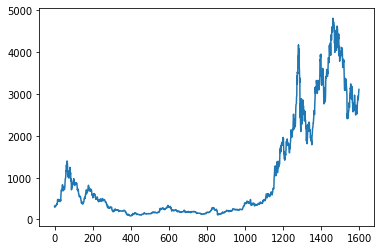

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1.shape

(1598, 1)

In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.875)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(1398, 200)

In [ ]:
train_data

array([[0.04747676],
       [0.05002152],
       [0.04534823],
       ...,
       [0.81544655],
       [0.80453217],
       [0.81832662]])

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_test.shape), print(ytest.shape)

(189, 10)
(189,)


(None, None)

In [ ]:
print(X_train.shape), print(y_train.shape)

(1387, 10)
(1387,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_10 (LSTM)              (None, 10, 50)            20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 5s 52ms/step - loss: 0.0192 - val_loss: 0.0048
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0077
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 5/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 7/100
22/22 [==============================] - 0s 8ms/step - loss: 9.5382e-04 - val_loss: 0.0040
Epoch 8/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 9/100
22/22 [==============================] - 0s 9ms/step - loss: 9.8544e-04 - val_loss: 0.0040
Epoch 10/100
22/22 [==============================] - 0s 9ms/step - loss: 9.6078e-04 - val_loss: 0.0

In [ ]:

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

6/6 [==============================] - 0s 4ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1080.5707262432034

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

3521.061008304774

In [ ]:
ytest.transpose()

array([0.73750362, 0.70107687, 0.70866607, 0.68674018, 0.6121791 ,
       0.56687424, 0.63348004, 0.64968636, 0.60235519, 0.60139413,
       0.63091191, 0.60194861, 0.57662676, 0.58578105, 0.61721928,
       0.68233874, 0.69966858, 0.70559537, 0.6977677 , 0.72628904,
       0.73903698, 0.74136851, 0.7354785 , 0.73865737, 0.70579649,
       0.7326176 , 0.72124932, 0.7449925 , 0.78418071, 0.80015945,
       0.79258239, 0.796364  , 0.77508351, 0.80271235, 0.86280438,
       0.84036859, 0.82252395, 0.8649506 , 0.84644996, 0.87457479,
       0.85655357, 0.81267565, 0.8896725 , 0.91624099, 0.89687926,
       0.88957321, 0.8968278 , 0.95336512, 0.95653795, 0.9423064 ,
       0.93071566, 0.93946213, 0.95970582, 1.        , 0.98376812,
       0.96305007, 0.98185179, 0.96966602, 0.96583885, 0.96128046,
       0.94930093, 0.87384957, 0.88948538, 0.8276814 , 0.89171746,
       0.91580755, 0.88497969, 0.84756186, 0.90053832, 0.88601343,
       0.93908697, 0.83768386, 0.85009446, 0.89142041, 0.92333

In [ ]:

ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [ ]:
ytest = ytest.transpose()

In [ ]:
ytest

array([[3569.568115, 3397.422852, 3433.287842, 3329.670654, 2977.310547,
        2763.209229, 3077.974365, 3154.562012, 2930.884766, 2926.343018,
        3065.837891, 2928.963379, 2809.297607, 2852.558838, 3001.129395,
        3308.870361, 3390.767578, 3418.776367, 3381.784424, 3516.570313,
        3576.814453, 3587.832764, 3559.997803, 3575.020508, 3419.726807,
        3546.477783, 3492.753662, 3604.958984, 3790.154297, 3865.666504,
        3829.858887, 3847.72998 , 3747.162842, 3877.730957, 4161.713379,
        4055.686523, 3971.356445, 4171.855957, 4084.425781, 4217.337891,
        4132.17334 , 3924.81543 , 4288.686523, 4414.243652, 4322.744141,
        4288.217285, 4322.500977, 4589.68457 , 4604.678711, 4537.42334 ,
        4482.647949, 4523.981934, 4619.649414, 4810.071289, 4733.362793,
        4635.453613, 4724.306641, 4666.719238, 4648.632813, 4627.09082 ,
        4570.478027, 4213.910645, 4287.802246, 3995.729492, 4298.350586,
        4412.195313, 4266.509277, 4089.68042 , 4340

In [ ]:
x = pd.to_datetime(df['Date'])

In [ ]:
x=x.iloc[-189:]

In [ ]:
x = x.transpose()

In [ ]:
x

1409   2021-09-18
1410   2021-09-19
1411   2021-09-20
1412   2021-09-21
1413   2021-09-22
          ...    
1593   2022-03-21
1594   2022-03-22
1595   2022-03-23
1596   2022-03-24
1597   2022-03-25
Name: Date, Length: 189, dtype: datetime64[ns]

In [ ]:
ytest

array([[3569.568115, 3397.422852, 3433.287842, 3329.670654, 2977.310547,
        2763.209229, 3077.974365, 3154.562012, 2930.884766, 2926.343018,
        3065.837891, 2928.963379, 2809.297607, 2852.558838, 3001.129395,
        3308.870361, 3390.767578, 3418.776367, 3381.784424, 3516.570313,
        3576.814453, 3587.832764, 3559.997803, 3575.020508, 3419.726807,
        3546.477783, 3492.753662, 3604.958984, 3790.154297, 3865.666504,
        3829.858887, 3847.72998 , 3747.162842, 3877.730957, 4161.713379,
        4055.686523, 3971.356445, 4171.855957, 4084.425781, 4217.337891,
        4132.17334 , 3924.81543 , 4288.686523, 4414.243652, 4322.744141,
        4288.217285, 4322.500977, 4589.68457 , 4604.678711, 4537.42334 ,
        4482.647949, 4523.981934, 4619.649414, 4810.071289, 4733.362793,
        4635.453613, 4724.306641, 4666.719238, 4648.632813, 4627.09082 ,
        4570.478027, 4213.910645, 4287.802246, 3995.729492, 4298.350586,
        4412.195313, 4266.509277, 4089.68042 , 4340

In [ ]:
test_predict = test_predict.transpose()

In [ ]:
test_predict

array([[3631.589 , 3686.7344, 3546.1729, 3468.7266, 3380.4065, 3104.0337,
        2828.8909, 2936.276 , 3136.134 , 3106.3186, 3038.9446, 3094.56  ,
        3063.973 , 2951.9824, 2912.2344, 3007.9543, 3280.8657, 3499.4094,
        3586.6313, 3552.676 , 3588.5264, 3649.3909, 3673.585 , 3643.1619,
        3621.587 , 3498.6138, 3519.4019, 3523.9238, 3601.6448, 3782.4443,
        3921.8777, 3920.7039, 3886.1282, 3777.1113, 3812.932 , 4067.7537,
        4105.346 , 3982.6895, 4055.4995, 4038.1611, 4104.0273, 4062.929 ,
        3851.2212, 4040.5532, 4283.6772, 4275.868 , 4173.434 , 4138.588 ,
        4350.879 , 4455.209 , 4377.81  , 4251.0234, 4226.296 , 4313.942 ,
        4511.1646, 4498.677 , 4345.319 , 4342.4614, 4314.4785, 4281.4185,
        4255.031 , 4204.7134, 3894.6914, 3853.1028, 3692.5134, 3904.623 ,
        4168.2686, 4145.135 , 3939.235 , 4056.8533, 4106.8613, 4308.5356,
        3994.7756, 3848.7097, 4010.3677, 4249.8193, 4474.303 , 4481.215 ,
        4345.479 , 4019.1252, 3803.8  

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=x, y=[3569.568115, 3397.422852, 3433.287842, 3329.670654, 2977.310547,
        2763.209229, 3077.974365, 3154.562012, 2930.884766, 2926.343018,
        3065.837891, 2928.963379, 2809.297607, 2852.558838, 3001.129395,
        3308.870361, 3390.767578, 3418.776367, 3381.784424, 3516.570313,
        3576.814453, 3587.832764, 3559.997803, 3575.020508, 3419.726807,
        3546.477783, 3492.753662, 3604.958984, 3790.154297, 3865.666504,
        3829.858887, 3847.72998 , 3747.162842, 3877.730957, 4161.713379,
        4055.686523, 3971.356445, 4171.855957, 4084.425781, 4217.337891,
        4132.17334 , 3924.81543 , 4288.686523, 4414.243652, 4322.744141,
        4288.217285, 4322.500977, 4589.68457 , 4604.678711, 4537.42334 ,
        4482.647949, 4523.981934, 4619.649414, 4810.071289, 4733.362793,
        4635.453613, 4724.306641, 4666.719238, 4648.632813, 4627.09082 ,
        4570.478027, 4213.910645, 4287.802246, 3995.729492, 4298.350586,
        4412.195313, 4266.509277, 4089.68042 , 4340.036133, 4271.394531,
        4522.208984, 4042.999023, 4101.648926, 4296.946777, 4447.768066,
        4623.679688, 4586.333008, 4514.355957, 4227.762207, 4119.628906,
        4199.      , 4358.586914, 4311.674316, 4433.024902, 4113.588379,
        3909.667725, 4084.811279, 4136.359863, 3782.822754, 3862.251465,
        4020.415039, 3959.012451, 3880.291504, 3960.872314, 3923.695801,
        3938.463867, 4018.695801, 3981.96167 , 4111.345215, 4049.781982,
        4094.151611, 4064.746338, 4037.538086, 3797.436279, 3632.219727,
        3713.430176, 3683.047119, 3769.29834 , 3829.535645, 3761.361572,
        3794.269043, 3549.708984, 3417.837891, 3193.502441, 3091.696289,
        3157.570557, 3082.990967, 3238.449951, 3372.10498 , 3248.648682,
        3309.844238, 3330.387207, 3350.947266, 3212.287598, 3163.850342,
        3095.271729, 3002.956787, 2561.145264, 2406.924316, 2535.891113,
        2440.393555, 2455.579102, 2467.188477, 2421.646973, 2546.590576,
        2598.564941, 2603.263428, 2687.898926, 2791.958984, 2682.226074,
        2681.057617, 2984.446045, 3014.959717, 3057.422119, 3143.008545,
        3121.182617, 3240.113037, 3077.413086, 2927.386475, 2916.789551,
        2880.187744, 2933.729004, 3180.446777, 3126.858398, 2884.340576,
        2784.872803, 2763.756592, 2627.665527, 2572.898682, 2639.447021,
        2588.16626 , 2598.436279, 2764.989502, 2780.504395, 2621.172119,
        2919.775879, 2972.471924, 2950.156738, 2834.987305, 2618.473633,
        2664.943604, 2555.297607, 2497.721436, 2577.165283, 2729.116455,
        2608.27124 , 2559.660645, 2573.488037, 2518.486328, 2590.668945,
        2620.028564, 2771.964111, 2814.43457 , 2944.72168 , 2946.547607,
        2860.103271, 2897.77417 , 2973.14502 , 3031.060791], name ='Open')
)


fig.add_trace(
    go.Scatter(x=x, y=[3631.589 , 3686.7344, 3546.1729, 3468.7266, 3380.4065, 3104.0337,
        2828.8909, 2936.276 , 3136.134 , 3106.3186, 3038.9446, 3094.56  ,
        3063.973 , 2951.9824, 2912.2344, 3007.9543, 3280.8657, 3499.4094,
        3586.6313, 3552.676 , 3588.5264, 3649.3909, 3673.585 , 3643.1619,
        3621.587 , 3498.6138, 3519.4019, 3523.9238, 3601.6448, 3782.4443,
        3921.8777, 3920.7039, 3886.1282, 3777.1113, 3812.932 , 4067.7537,
        4105.346 , 3982.6895, 4055.4995, 4038.1611, 4104.0273, 4062.929 ,
        3851.2212, 4040.5532, 4283.6772, 4275.868 , 4173.434 , 4138.588 ,
        4350.879 , 4455.209 , 4377.81  , 4251.0234, 4226.296 , 4313.942 ,
        4511.1646, 4498.677 , 4345.319 , 4342.4614, 4314.4785, 4281.4185,
        4255.031 , 4204.7134, 3894.6914, 3853.1028, 3692.5134, 3904.623 ,
        4168.2686, 4145.135 , 3939.235 , 4056.8533, 4106.8613, 4308.5356,
        3994.7756, 3848.7097, 4010.3677, 4249.8193, 4474.303 , 4481.215 ,
        4345.479 , 4019.1252, 3803.8   , 3851.7725, 4066.4426, 4138.197 ,
        4232.7095, 4000.1748, 3708.2317, 3773.3103, 3927.0654, 3724.1685,
        3669.8271, 3829.3555, 3889.3035, 3831.0083, 3857.3196, 3857.1396,
        3862.3372, 3929.4673, 3933.6035, 4016.6353, 4005.7524, 4008.235 ,
        3981.677 , 3938.9248, 3732.253 , 3515.3586, 3526.0066, 3576.0642,
        3682.5806, 3790.6257, 3780.5513, 3776.4329, 3593.0251, 3399.2097,
        3183.3708, 3050.1106, 3084.775 , 3106.4417, 3228.8203, 3402.8994,
        3404.2852, 3399.916 , 3408.9392, 3424.1777, 3333.7966, 3239.5535,
        3158.9854, 3074.3745, 2765.945 , 2507.3477, 2492.4868, 2499.8809,
        2521.7632, 2547.5444, 2539.7341, 2592.181 , 2663.2646, 2703.797 ,
        2762.5955, 2854.5637, 2842.831 , 2805.0864, 2954.3748, 3096.5615,
        3180.6492, 3251.1924, 3259.746 , 3316.933 , 3242.5842, 3076.1306,
        2980.589 , 2939.0273, 2970.019 , 3160.6677, 3254.7246, 3110.8774,
        2928.8018, 2830.472 , 2729.4773, 2655.9048, 2672.8403, 2680.8433,
        2689.9302, 2788.1401, 2869.8545, 2811.1187, 2914.3977, 3040.7332,
        3087.3208, 3013.181 , 2816.4766, 2726.1062, 2652.5256, 2590.9082,
        2613.1636, 2736.6848, 2756.148 , 2707.606 , 2673.9685, 2631.518 ,
        2648.1357, 2688.718 , 2800.4915, 2900.5703, 3017.8003, 3075.3547,
        3028.981 , 2999.1472, 3034.3438] , name = 'Predicted_LSTM(Open)')
)

fig.show()